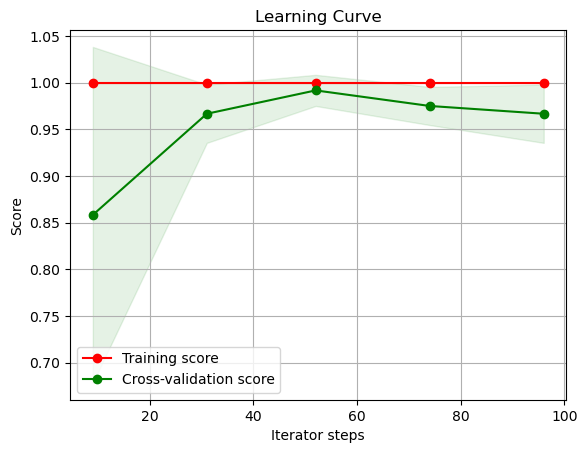

1.0
1.0
1.0
1.0


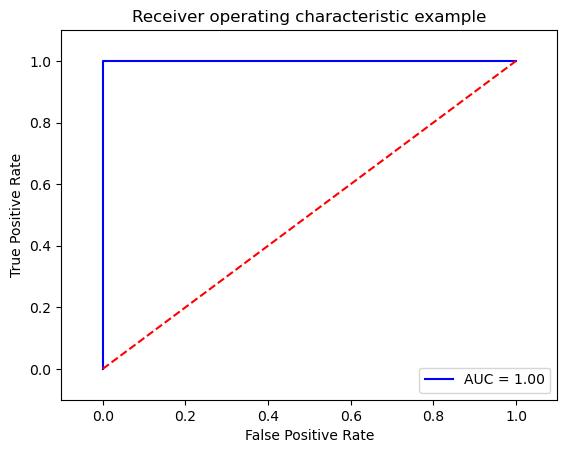

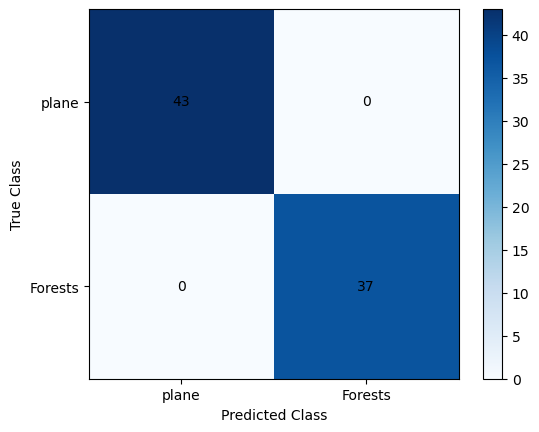

<Figure size 640x480 with 0 Axes>

In [4]:
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve


#绘制学习曲线，以确定模型的状况
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    画出data在某模型上的learning curve.
    参数解释
    ----------
    estimator : 使用的分类器。
    title : 标题
    X : 输入的feature，numpy类型
    y : 输入的target vector
    ylim : tuple格式的(ymin, ymax), 设定图像中纵坐标的最低点和最高点
    cv : 做cross-validation的时候，数据分成的份数，其中一份作为cv集，其余n-1份作为training(默认为3份)
    """
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Iterator steps")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on")
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    plt.show()


# https://blog.csdn.net/qq_36158230/article/details/118670801
# 加载训练数据集
def load_dataset(path):
    dataset_file = csv.reader(open(path))
    vector_x = []   # 样本
    y = []          # 样本所对应的标签
    # 从文件读取训练数据集
    for content in dataset_file:
        # 如果读取的不是表头
        if dataset_file.line_num != 1:
            # 读取一行并转化为列表
            content = list(map(float, content))
            if len(content) != 0:
                vector_x.append(content[1:12])  # 第1-12列是样本的特征
                y.append(content[-1])           # 最后一列是样本的标签
    return vector_x, y  # 返回训练数据集

# 训练模型
def mlp_cls(vector_x_train, y_train):
    # MLPClassifier参数说明详情见https://www.cnblogs.com/-X-peng/p/14225973.html
    # sgd不好 lbfgs和adam好
    # 模型的参数是11×500×100×50×10×2+500+100+50+10+2=550000660个，其中权重参数2.75e8个，偏置值662个
    mlp = MLPClassifier(activation='tanh', max_iter=1000, solver='adam', learning_rate_init=0.001, alpha=0, hidden_layer_sizes=(500, 100, 50, 10))
    mlp.fit(vector_x_train, y_train)        # 训练
    plot_learning_curve(mlp, 'Learning Curve', vector_x_train, y_train, ylim=None, cv=6, train_sizes=np.linspace(.1, 1.0, 5))
    return mlp

# 模型预测
def mlp_cls_predict(mlp, vector_x_test, y_test):
    # 预测
    y_predict = mlp.predict(vector_x_test)
    # 输出模型预测的准确率，召回率，
    print(accuracy_score(y_predict, y_test))
    print(recall_score(y_predict, y_test))
    print(precision_score(y_predict, y_test))
    print(f1_score(y_predict, y_test))

    #ROC曲线
    y_probs = mlp.predict_proba(vector_x_test) #模型的预测得分
    y_probs = y_probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,y_probs)
    roc_auc = auc(fpr, tpr)  #auc为Roc曲线下的面积
    #开始画ROC曲线
    plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate') #横坐标是fpr
    plt.ylabel('True Positive Rate')  #纵坐标是tpr
    plt.title('Receiver operating characteristic example')
    plt.show()


    names = np.array(['plane', 'Forests'])
    # 绘制混淆矩阵（使用热力图）
    cm = confusion_matrix(y_test, y_predict) # 计算混淆矩阵
    plt.imshow(cm, cmap='Blues') # 绘制热力图
    plt.colorbar() # 显示颜色条
    plt.xticks([0, 1], names) # 设置x轴刻度和标签
    plt.yticks([0, 1], names) # 设置y轴刻度和标签
    plt.xlabel('Predicted Class') # 设置x轴标签
    plt.ylabel('True Class') # 设置y轴标签
    for i in range(2): # 在每个格子中显示数字
        for j in range(2):
            plt.text(j, i, cm[i][j], ha='center', va='center')
    plt.show()
    plt.savefig('Confusion matrix-MLP')

# 实验
if __name__ == '__main__':
    # 1. 加载数据集
    vector_x, y = load_dataset("C:/Users/14838/Desktop/MachineLearning/features.csv")
    scalar = StandardScaler()               # 标准化转换
    scalar.fit(vector_x)                    # 训练标准化对象
    vector_x = scalar.transform(vector_x)   # 转换数据集
    # 2. 划分训练集和测试集
    vector_x_train, vector_x_test, y_train, y_test = train_test_split(vector_x, y, test_size=0.4)
    # 3. 训练
    mlp = mlp_cls(vector_x_train, y_train)
    # 4. 预测
    mlp_cls_predict(mlp, vector_x_test, y_test)
